In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Hawkes Processes

## 1st method: Ogata

On va prendre une intensité initiale lambda = 1, et on ajoute e^(s-t) à chaque évènement

In [2]:
Tmax = 20
Lambda_init = 1

J'essaie de faire une fonction pour actualiser l'intensité du processus :

In [3]:
def jump(t,Time_jumps,n_jumps, Lambda_i): # Intensité du processus de Hawkes au temps t
    val = Lambda_i
    for j in range(0,n_jumps):
        if (t >= Time_jumps[j]):
            val += np.exp(-2*(t-Time_jumps[j]))
    return(val)

En utilisant le code du poisson inhomogène :

In [4]:
T = []
t = 0
i = 1
x = []
y = []
Lambda_Hawkes = Lambda_init
Lambda_bar = [Lambda_Hawkes]

while(t < Tmax):
    # Tirage d'un nouveau temps aléatoire, selon l'intensité modifiée
    t = t + np.random.exponential(1/Lambda_bar[-1])    

    if(t >= Tmax):# Si on dépasse le temps limite, fin de la boucle
        x.append(Tmax)
        #Lambda_bar.append(Lambda_bar[-1])
        break
    

    x.append(t)
    # On tire selon une loi uniforme pour faire une acceptation rejet
    u = np.random.uniform(0,1)
    y.append(u*Lambda_bar[-1])
    # On actualise l'intensité 
    Lambda_Hawkes = jump(t,T,len(T), Lambda_init)
    if(u <= Lambda_Hawkes/Lambda_bar[-1] ):
        T.append(t)
        Lambda_Hawkes = jump(t,T,len(T), Lambda_init)
    Lambda_bar.append(Lambda_Hawkes) 

In [5]:
jump_values = [jump(t, T, len(T), Lambda_init) for t in np.linspace(0,Tmax, 1000)]

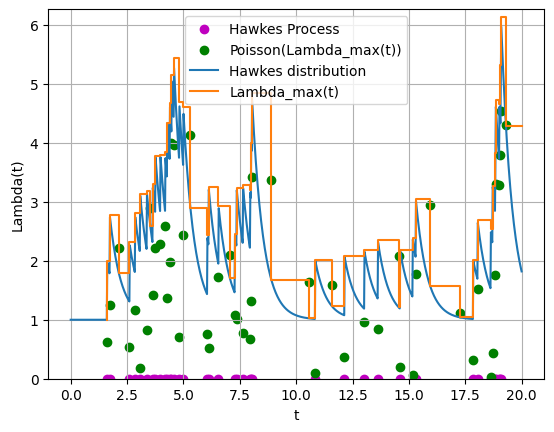

In [6]:
# Show plot
plt.grid(True)
plt.scatter(T, [0]*len(T), color='m', label='Hawkes Process')
plt.scatter(x[:-1], np.array(y), color='g', label='Poisson(Lambda_max(t))')
plt.plot(np.linspace(0, Tmax, 1000), jump_values, label='Hawkes distribution')
plt.ylim(0)
plt.step(x, Lambda_bar, where='pre', label='Lambda_max(t)')
plt.xlabel('t')
plt.ylabel('Lambda(t)')
plt.legend()
plt.grid(True)

# Save the plot as "hawkes_ogata.png"
plt.savefig('hawkes_ogata_int.png')


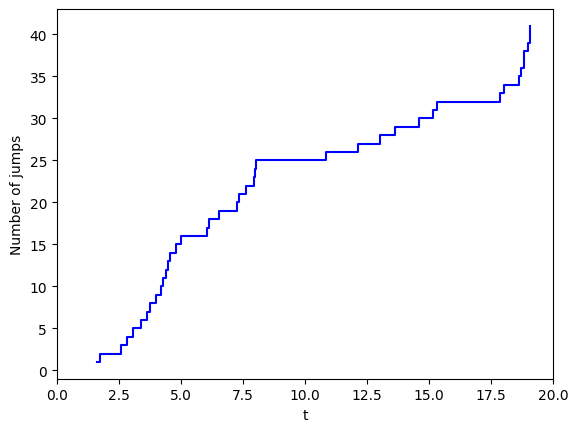

In [7]:
plt.step(T, np.arange(1, len(T) + 1), where='post', color='blue')
plt.xlim(0,Tmax)
plt.xlabel('t')
plt.ylabel('Number of jumps')
plt.savefig('hawkes_ogata.png')


## 2cd method: Superposition of Poisson Processes

Pour que ça fonctionne bien, il faut penser à vectoriser tout ça. Première étape : on tire le nombre d'évènements suivant une loi de Poisson de paramètre Lambda_0, et on les répartis uniformément sur l'intervalle voulu. Pour chaque évènement, on va tirer la génération d'après suivant une loi h(.-T_i), h étant une exponentielle décroissante.

In [8]:
Tmax = 20
Lambda_init = 1
alpha = 1
beta = 2

In [12]:
def jump(t,Time_jumps,n_jumps, Lambda_i, alpha, beta): # Fonction d'intensité du processus de Hawkes au temps t
    val = Lambda_i
    
    for j in range(0,n_jumps):
        if (t >= Time_jumps[j]):
            val += alpha*np.exp(-beta*(t-Time_jumps[j]))
    return(val)

def next_gen(T, Lambda_i, Lambda_bar, alpha, beta, Tmax, N): # Simulation des temps d'apparition des enfants pour un parent donné.
    t = 0
    time = []
    i = 0
    while(i < N):
        t = T[-1] + np.random.exponential(1/Lambda_bar)
        u = np.random.uniform(0,1)
        if(t >= Tmax):
            break
        if(u <= jump(t, T, len(T), Lambda_i, alpha, beta)/Lambda_bar ):
            time.append(t)
        i += 1
    return(time)


First generation :

In [14]:
num_immigrant = np.random.poisson(Lambda_init * Tmax)
hawkes = np.sort(np.random.uniform(0, Tmax, num_immigrant))
print("Nombre d'immigrants : " + str(num_immigrant))

Nombre d'immigrants : 16


Now, we take the next generation, following an inhomogenous Poisson process.

In [11]:
gen = hawkes
while(len(gen) != 0):
    events = np.array(list(map(lambda t: next_gen([t], Lambda_init, Lambda_bar, alpha, beta, Tmax, N)[0], gen)))
    if(len(events) != 0):
        hawkes = np.concatenate((hawkes, events))
        gen = events

for imm in events:
    Lambda_bar = Lambda_init + 1
    cluster = [imm]
    N = np.random.poisson(alpha/beta)
    time = next_gen(cluster, Lambda_init, Lambda_bar, alpha, beta, Tmax,N)
    while len(time)!= 0 :
        cluster = np.concatenate((cluster, time))
hawkes = np.sort(events)
print(events)

TypeError: can only concatenate list (not "float") to list